In [2]:
#=====================================================
# Nome:   Diego Andrés Méndez
# N. USP: 7991531
#=====================================================

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import PIL
import pandas as pd
import datetime

from mac0460_5832.utils import *

In [4]:
print(datetime.datetime.now().strftime('%d/%m/%Y %H:%M:%S'))

09/10/2018 19:33:36


# MAC0460/5832 - Lista 1: Aprendizado de W-Operadores

## Data de Entrega: 23h55m do dia 01/10/2018

Envie o notebook Python (extensão .ipynb) para tanoued@ime.usp.br e ricardoy@ime.usp.br. O nome do arquivo deve ser ```<seu nome>_<seu nUSP>.ipynb```, ou ```<seu nome>.ipynb```, caso não tenha número USP.

In [5]:
#adiciona border_size camadas de borda à imagem src
#Usa a função border para inputar os valores da borda
def add_border(src,border_size,border):
    border_src=np.zeros([src.shape[0]+2*border_size,src.shape[1]+2*border_size]).astype(bool)
    for i in range(len(border_src)):
        for j in range(len(border_src[i])):
            if i in range(border_size,src.shape[0]+border_size) and j in range(border_size,src.shape[1]+border_size):
                border_src[i,j]=src[i-border_size,j-border_size]
            else:
                border_src[i][j]=border(i-border_size,j-border_size)
    return border_src

In [6]:
# list_src_dest é uma lista de duplas para treinamento do operador W.
# O primeiro elemento de cada dupla é a imagem original e o segundo é a imagem desejada depois de aplicar o operador W.

# multi_window é uma lista multiresolução de janelas, da maior para a menor
# caso multi_window só possua uma janela, o caso se reduz ao de um w-operador comum

#border é uma função que retorna valores booleanos para os pontos fora da imagem src.

# Se track training for igual a True, todos os w_operadores intermediarios gerados a cada pixel treinado
# vão sendo adicionados à variável global track

def train_w_operator(list_src_dest,multi_window,border,multi_w_operator=None,track_training=False,limit=None):
    if track_training==True:
        global track
    if len(list_src_dest)==0:
        raise Exception('As lista list_src_dest tem comprimento 0!')
    
    if multi_w_operator==None:
        multi_w_operator=[]
        for i in range(len(multi_window)):
            multi_w_operator.append({})

    pad=abs(np.array(multi_window[0])).max()
    cont=0
    
    pontos=0
    
    # para cada dupla de imagens
    for src,dest in list_src_dest:
        src_pad=add_border(src,pad,border)
        print('Imagem '+str(cont+1)+' de '+str(len(list_src_dest))+'.')

        #para cada linha da imagem original
        for i in range(len(src)):
            if (i+1)%100==0:
                print('Linha '+str(i+1)+' de '+str(len(src))+'.')

            #para cada ponto da linha da imagem original
            for j in range(len(src[i])):

                for k in range(len(multi_window)):
                    window=list(set(multi_window[k]))
                    window=sorted(window)
                    window=np.array(window)
                    window_transladada=window+np.array([i+pad,j+pad])
                    index_true=src_pad[tuple(window_transladada.transpose())].nonzero()
                    pontos_true=window[index_true]
                    pontos_tuple=tuple(map(tuple,pontos_true))

                    if dest[i,j]==True:
                        multi_w_operator[k][pontos_tuple]=multi_w_operator[k].get(pontos_tuple,0)+1
                    else:
                        multi_w_operator[k][pontos_tuple]=multi_w_operator[k].get(pontos_tuple,0)-1
                    if track_training==True:
                        track.append([dict(w_operator) for w_operator in multi_w_operator])
                pontos+=1
                if limit!=None and pontos>=limit:
                    return multi_w_operator
        cont+=1
        
    #retorna uma lista de dicionários, onde cada dicionário é um w-operador relativo a uma resolução de multi_window
    return multi_w_operator

In [7]:
# src é a imagem onde desejamos aplicar o operador W

# w_operator é o operador W já treinado

# multi_window é uma lista multiresolução de janelas, da maior para a menor
# caso multi_window só possua uma janela, o caso se reduz ao de um w-operador comum

# border é uma função que retorna valores booleanos para os pontos fora da imagem src.

# default é o valor atribuido a um pixel caso a sua janela não tenha sido vista no treinamento
# caso seja igual a 'src', o valor do próprio pixel é mantido
# caso seja igual a '-src', o valor do próprio pixel é invertido

# threshold é o limiar de ocorrencias do número de True menos o número de False encontrados para aquela janela
# para definir se o operador deve usar aquela janela ou uma de resolução menor

def apply_w_operator(src,multi_w_operator,multi_window,border,default=False,threshold=[]):
    
    if threshold==[]:
        threshold=[0]*len(multi_window)
    
    #cria a imagem de destino
    dest=np.zeros(src.shape,np.bool)
    
    pad=abs(np.array(multi_window[0])).max()
    
#     src_pad=np.pad(src,pad,'constant')
    src_pad=add_border(src,pad,border)
    
    #para cada linha da imagem original
    for i in range(len(src)):
        if (i+1)%100==0:
            print('Linha '+str(i+1)+' de '+str(len(src))+'.')
        
        #para cada ponto da linha da imagem original
        for j in range(len(src[i])):
            for k in range(len(multi_window)):
                window=list(set(multi_window[k]))
                window=sorted(window)
                window=np.array(window)
                window_transladada=window+np.array([i+pad,j+pad])
                index_true=src_pad[tuple(window_transladada.transpose())].nonzero()
                pontos_true=window[index_true]
                pontos_tuple=tuple(map(tuple,pontos_true))

                if multi_w_operator[k].get(pontos_tuple,0)>threshold[k]:
                    dest[i,j]=True
                    break
                elif multi_w_operator[k].get(pontos_tuple,0)<-threshold[k]:
                    dest[i,j]=False
                    break
                elif default=='src':
                    dest[i,j]=src_pad[i+pad,j+pad]
                elif default=='-src':
                    dest[i,j]= not src_pad[i+pad,j+pad]
                else:
                    dest[i,j]=default
                
    return dest

In [8]:
def rectangular_window(y,x):
    window=[]
    for i in range(-y,y+1):
        for j in range(-x,x+1):
            window.append((i,j))
    return(window)

In [9]:
def cross_window(n):
    cross=[(0,0)]
    for i in range(1,n+1):
        cross+=[(0,i),(0,-i),(i,0),(-i,0)]
    return cross

In [10]:
def cross_point_window(i):
    cross=[(0,i),(0,-i),(i,0),(-i,0)]
    
    return cross

# Questões

## Questão 1

Encontre, utilizando a técnica de aprendizado de w-operadores vista em sala, o operador 1x3 (1 linha, 3 colunas) capaz de transformar a imagem src1 em dest1 (veja as variáveis abaixo) mostrando a tabela de padrões encontrada. Teste seu operador na imagem src1 e verifique que ele funciona como esperado. Teste seu operador nas imagens images/q1/1_test1.png e images/q1/1_test2.png desenhando as imagens obtidas (sugestão: use a função draw_img do arquivo mac0460_5832/utils.py).

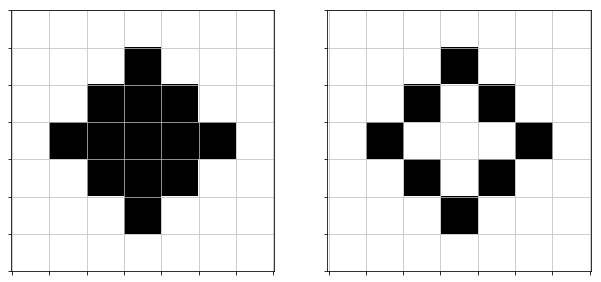

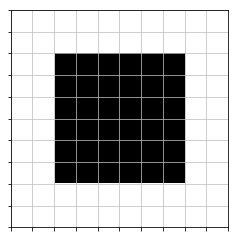

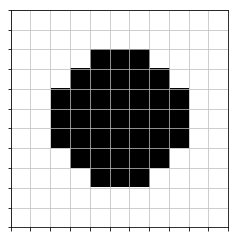

In [11]:
src1 = read_img('images/q1/1_src.png')
dest1 = read_img('images/q1/1_dest.png')

draw_img_pair(src1, dest1)

test1_1 = read_img('images/q1/1_test1.png')
test1_2 = read_img('images/q1/1_test2.png')
draw_img(test1_1)
draw_img(test1_2)

## Resolução da questão 1

In [12]:
src=[src1]
dest=[dest1]
window=[[(0,-1),(0,0),(0,1)]]
def border(i,j):
    return False

w_operator=train_w_operator(list(zip(src,dest)),window,border)


Imagem 1 de 1.


In [13]:
w_operator

[{(): -26,
  ((0, -1),): -5,
  ((0, -1), (0, 0)): 3,
  ((0, -1), (0, 0), (0, 1)): -5,
  ((0, 0),): 2,
  ((0, 0), (0, 1)): 3,
  ((0, 1),): -5}]

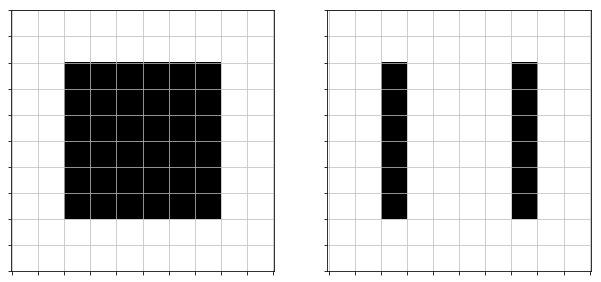

In [13]:
test=test1_1

test_dest=apply_w_operator(test,w_operator,window,border)
draw_img_pair(test,test_dest)

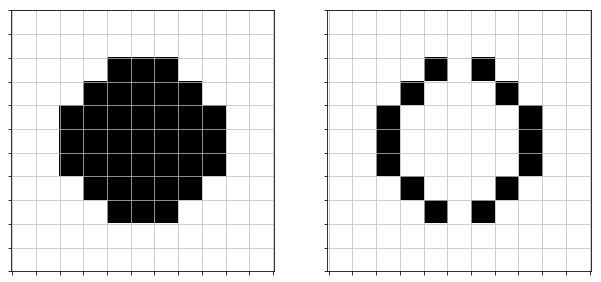

In [14]:
test=test1_2

test_dest=apply_w_operator(test,w_operator,window,border)
draw_img_pair(test,test_dest)

## Questão 2

Aprenda o operador 3x3 para detecção de bordas. Treine seu operador nas imagens da pastas images/q2/ usando os pares (q2_src\*.png, q2_dest\*.png). Teste seu operador nas imagens images/q2/q2_test.png e images/q2/q2_test2.png. Algumas das imagens de treino são desenhadas abaixo.

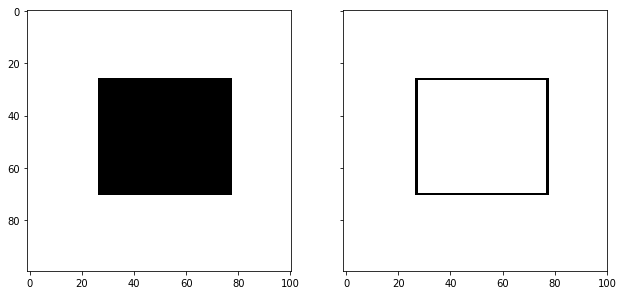

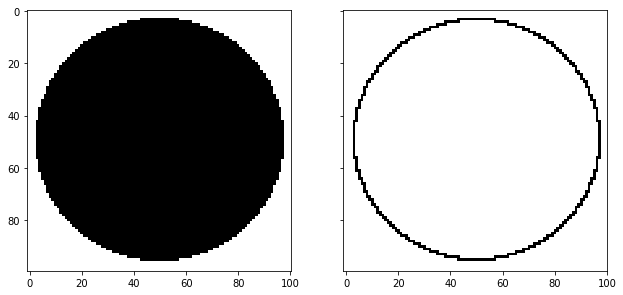

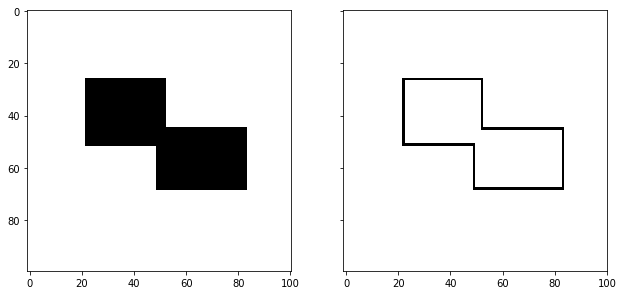

In [19]:
src2_1 = read_img('images/q2/q2_src1.png')
src2_2 = read_img('images/q2/q2_src2.png')
src2_3 = read_img('images/q2/q2_src3.png')
src2_4 = read_img('images/q2/q2_src4.png')
src2_5 = read_img('images/q2/q2_src5.png')

dest2_1 = read_img('images/q2/q2_dest1.png')
dest2_2 = read_img('images/q2/q2_dest2.png')
dest2_3 = read_img('images/q2/q2_dest3.png')
dest2_4 = read_img('images/q2/q2_dest4.png')
dest2_5 = read_img('images/q2/q2_dest5.png')

draw_img_pair(src2_1, dest2_1)
draw_img_pair(src2_2, dest2_2)
draw_img_pair(src2_3, dest2_3)

In [20]:
src=[src2_1,src2_2,src2_3,src2_4,src2_5]
dest=[dest2_1,dest2_2,dest2_3,dest2_4,dest2_5]
window=[[(-1,-1),(-1,+0),(-1,+1),
         (+0,-1),(+0,+0),(+0,+1),
         (+1,-1),(+1,-0),(+1,+1)]]

def border(i,j):
    return False

w_operator=train_w_operator(list(zip(src,dest)),window,border)


Imagem 1 de 5.
Linha 100 de 100.
Imagem 2 de 5.
Linha 100 de 100.
Imagem 3 de 5.
Linha 100 de 100.
Imagem 4 de 5.
Linha 100 de 100.
Imagem 5 de 5.
Linha 100 de 100.


In [21]:
w_operator

[{(): -31073,
  ((-1, -1),): -52,
  ((-1, -1), (-1, 0)): -22,
  ((-1, -1), (-1, 0), (-1, 1)): -230,
  ((-1, -1), (-1, 0), (-1, 1), (0, -1)): -17,
  ((-1, -1), (-1, 0), (-1, 1), (0, -1), (0, 0)): 19,
  ((-1, -1), (-1, 0), (-1, 1), (0, -1), (0, 0), (0, 1)): 228,
  ((-1, -1), (-1, 0), (-1, 1), (0, -1), (0, 0), (0, 1), (1, -1)): 17,
  ((-1, -1), (-1, 0), (-1, 1), (0, -1), (0, 0), (0, 1), (1, -1), (1, 0)): 47,
  ((-1, -1),
   (-1, 0),
   (-1, 1),
   (0, -1),
   (0, 0),
   (0, 1),
   (1, -1),
   (1, 0),
   (1, 1)): -16196,
  ((-1, -1), (-1, 0), (-1, 1), (0, -1), (0, 0), (0, 1), (1, 0), (1, 1)): 49,
  ((-1, -1), (-1, 0), (-1, 1), (0, -1), (0, 0), (0, 1), (1, 1)): 19,
  ((-1, -1), (-1, 0), (-1, 1), (0, -1), (0, 0), (1, -1)): 16,
  ((-1, -1), (-1, 0), (-1, 1), (0, -1), (0, 0), (1, -1), (1, 0)): 12,
  ((-1, -1), (-1, 0), (-1, 1), (0, 0), (0, 1)): 20,
  ((-1, -1), (-1, 0), (-1, 1), (0, 0), (0, 1), (1, 0), (1, 1)): 13,
  ((-1, -1), (-1, 0), (-1, 1), (0, 0), (0, 1), (1, 1)): 16,
  ((-1, -1), (-1, 0

Linha 100 de 200.
Linha 200 de 200.


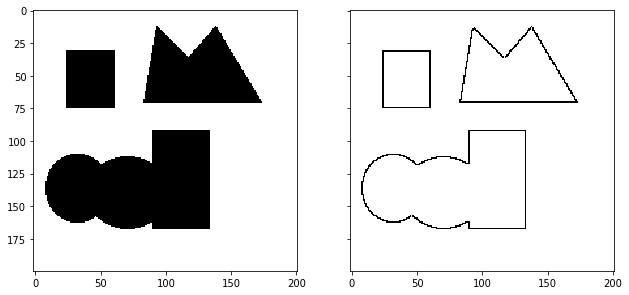

In [22]:
test=read_img('images/q2/q2_test.png')

test_dest=apply_w_operator(test,w_operator,window,border)
draw_img_pair(test,test_dest)

Linha 100 de 500.
Linha 200 de 500.
Linha 300 de 500.
Linha 400 de 500.
Linha 500 de 500.


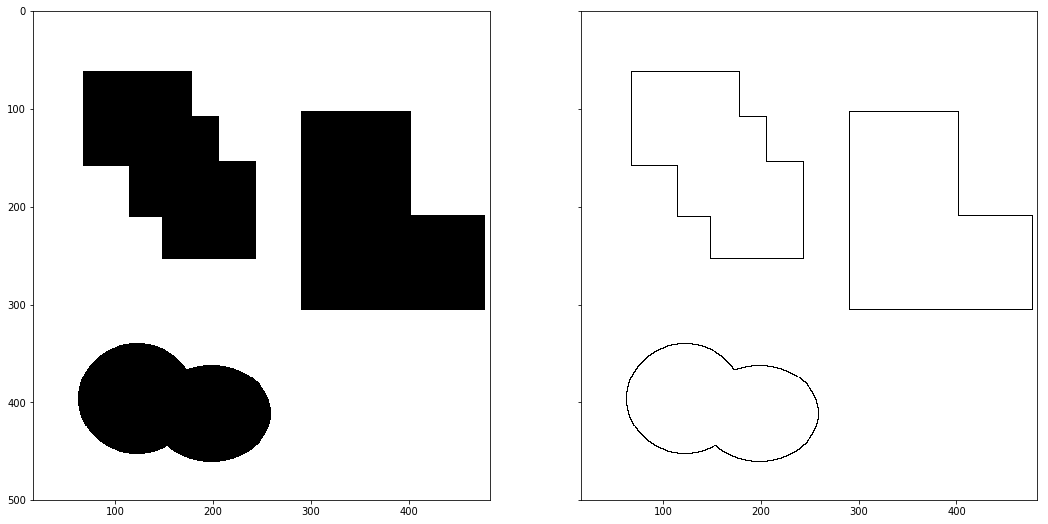

In [34]:
test=read_img('images/q2/q2_test2.png')

test_dest=apply_w_operator(test,w_operator,window,border)
draw_img_pair(test,test_dest,figsz=(18, 9))


## Questão 3

Use o algoritmo de aprendizado para obter um operador capaz de eliminar ruído. Use no treinamento as imagens images/q3/q3_src\*.png sempre com o mesmo target images/q3/q3_dest.png. Teste a janela com 5 elementos (cruz). Teste seu operador nas imagens images/q3/q3_test1.png e images/q3/q3_test2.png. Calcule e plote os erros $E_{in}$ e $E_{out}$ obtidos durante o treinamento.

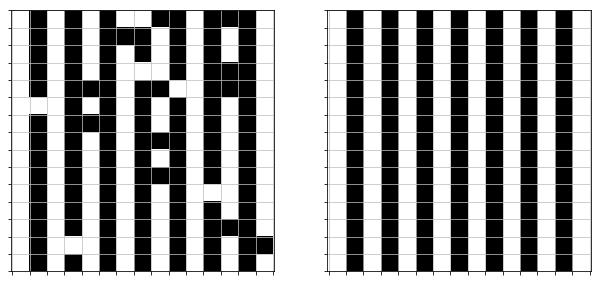

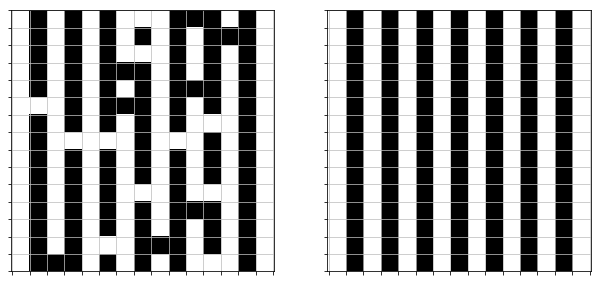

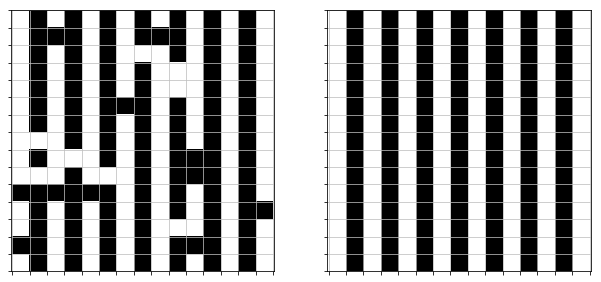

In [20]:
for i in range(1,10+1):
    globals()['src3_'+str(i)]=read_img('images/q3/q3_src'+str(i)+'.png')
dest3 = read_img('images/q3/q3_dest.png')

draw_img_pair(src3_1, dest3)
draw_img_pair(src3_2, dest3)
draw_img_pair(src3_3, dest3)

In [21]:
src=[globals()['src3_'+str(i)] for i in range(1,10+1)]
dest=[dest3]*len(range(10+1))
window=[[        (-1,+0),
         (+0,-1),(+0,+0),(+0,+1),
                 (+1,-0)         ]]
def border(i,j):
    if j%2==0:
        return False
    else:
        return True

track=[]
w_operator=train_w_operator(list(zip(src,dest)),window,border,track_training=True)


Imagem 1 de 10.
Imagem 2 de 10.
Imagem 3 de 10.
Imagem 4 de 10.
Imagem 5 de 10.
Imagem 6 de 10.
Imagem 7 de 10.
Imagem 8 de 10.
Imagem 9 de 10.
Imagem 10 de 10.


In [22]:
w_operator

[{(): -2,
  ((-1, 0),): 4,
  ((-1, 0), (0, -1)): -3,
  ((-1, 0), (0, -1), (0, 0)): 4,
  ((-1, 0), (0, -1), (0, 0), (0, 1)): -11,
  ((-1, 0), (0, -1), (0, 0), (0, 1), (1, 0)): 6,
  ((-1, 0), (0, -1), (0, 0), (1, 0)): 59,
  ((-1, 0), (0, -1), (0, 1)): -73,
  ((-1, 0), (0, -1), (0, 1), (1, 0)): -4,
  ((-1, 0), (0, -1), (1, 0)): 4,
  ((-1, 0), (0, 0)): 57,
  ((-1, 0), (0, 0), (0, 1)): 4,
  ((-1, 0), (0, 0), (0, 1), (1, 0)): 72,
  ((-1, 0), (0, 0), (1, 0)): 688,
  ((-1, 0), (0, 1)): -4,
  ((-1, 0), (0, 1), (1, 0)): 5,
  ((-1, 0), (1, 0)): 61,
  ((0, -1),): -61,
  ((0, -1), (0, 0)): -6,
  ((0, -1), (0, 0), (0, 1)): -69,
  ((0, -1), (0, 0), (0, 1), (1, 0)): -10,
  ((0, -1), (0, 0), (1, 0)): 7,
  ((0, -1), (0, 1)): -806,
  ((0, -1), (0, 1), (1, 0)): -63,
  ((0, -1), (1, 0)): -6,
  ((0, 0),): 5,
  ((0, 0), (0, 1)): -5,
  ((0, 0), (0, 1), (1, 0)): 7,
  ((0, 0), (1, 0)): 55,
  ((0, 1),): -62,
  ((0, 1), (1, 0)): -7,
  ((1, 0),): 4}]

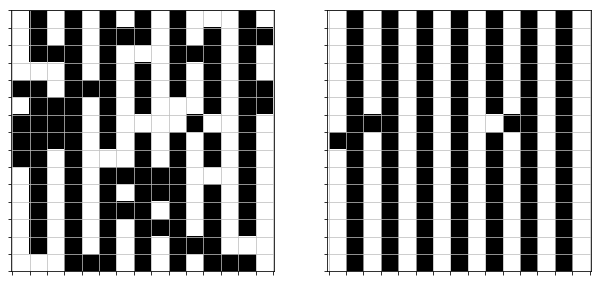

In [23]:
test=read_img('images/q3/q3_test1.png')

test_dest=apply_w_operator(test,w_operator,window,border)
draw_img_pair(test,test_dest)

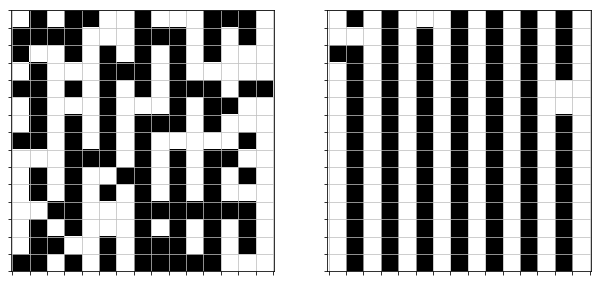

In [24]:
test=read_img('images/q3/q3_test2.png')

test_dest=apply_w_operator(test,w_operator,window,border)
draw_img_pair(test,test_dest)

In [25]:
n_in=0
for i in range(1,10+1):
    globals()['src3_'+str(i)]=read_img('images/q3/q3_src'+str(i)+'.png')
    n_in+=globals()['src3_'+str(i)].size

n_out=0
for i in range(1,2+1):
    globals()['test3_'+str(i)]=read_img('images/q3/q3_test'+str(i)+'.png')
    n_out+=globals()['test3_'+str(i)].size
    
error=[]

list_e_in=[]
list_e_out=[]

full_dest=np.empty((0,15))
for i in range(1,10+1):
    full_dest=np.concatenate((full_dest,dest3))
full_dest=full_dest.flatten()
    
for i in range(len(track)):
    if i%200==0:
        print(i)
    e_in=0
    e_out=0
    n_in=i+1
    in_test_dest=np.empty((0,15))
    
    
    for j in range(1,10+1):
        test=globals()['src3_'+str(j)]
        test_dest=apply_w_operator(test,track[i],window,border)
        in_test_dest=np.concatenate((in_test_dest,test_dest))
    in_test_dest=in_test_dest.flatten()
    e_in=(in_test_dest[:i+1]!=full_dest[:i+1]).sum()
        
#     e_in+=(test_dest!=dest3).sum()
    for j in range(1,2+1):
        test=globals()['test3_'+str(j)]
        test_dest=apply_w_operator(test,track[i],window,border)
        e_out+=(test_dest!=dest3).sum()
    list_e_in.append(e_in/n_in)
    list_e_out.append(e_out/n_out)

0
200
400
600
800
1000
1200
1400
1600
1800
2000
2200


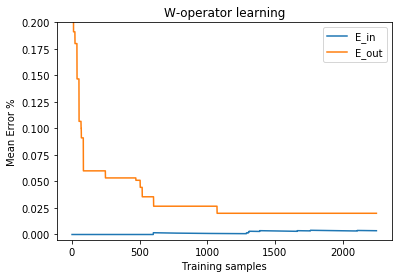

In [26]:
plt.plot(range(1,len(list_e_in)+1),list_e_in)
plt.plot(range(1,len(list_e_out)+1),list_e_out)
plt.ylabel('Mean Error %')
plt.xlabel('Training samples')
plt.title('W-operator learning')
plt.legend(['E_in', 'E_out'], loc='upper right')
plt.axis(ymax=0.2,ymin=-0.005)
plt.show()

## Questão 4

Projete um operador para aprender a extrair a letra 's' de imagens de texto. Para isso utilize os pares de imagens q4_src\*.png q4_dest\*.png da pasta images/q4/train. Teste seu operador nas imagens da pasta images/q4/test. Utilize a composição de janelas pequenas. Avalie o erro do seu operador comparando a saída obtida por ele com a saída esperada (imagens q4_gt\*.png da pasta images/q4/test).

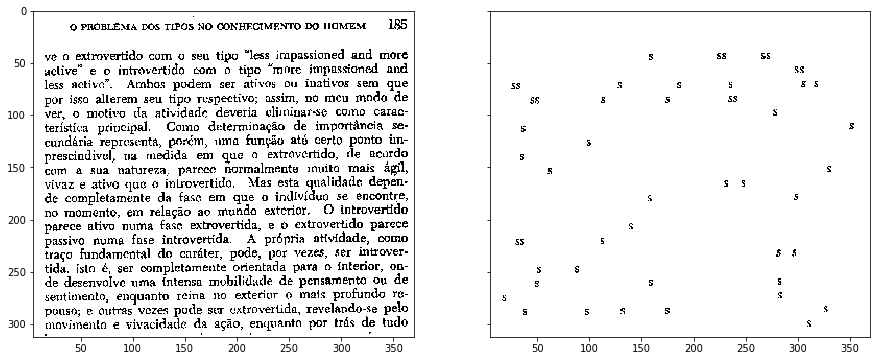

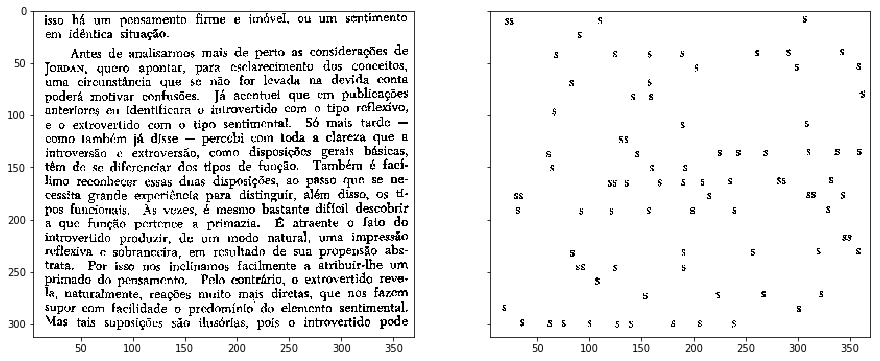

In [27]:
dest4_1a = read_img("images/q4/train/q4_dest1a.png")
src4_1a = read_img("images/q4/train/q4_src1a.png")
dest4_1b = read_img("images/q4/train/q4_dest1b.png")
src4_1b = read_img("images/q4/train/q4_src1b.png")
draw_img_pair(src4_1a, dest4_1a, figsz=(15, 6))
draw_img_pair(src4_1b, dest4_1b, figsz=(15, 6))

In [28]:
test=[]
test_dest=[]
for j in ['a','b']:
    for i in range(2,10+1,2):
        test.append(read_img('images/q4/test/q4_test'+str(i)+j+'.png'))
        test_dest.append(read_img('images/q4/test/q4_gt'+str(i)+j+'.png'))

src_a=[]
dest_a=[]
for i in range(1,9+1,2):
    globals()['src4_'+str(i)+'a']=read_img("images/q4/train/q4_src"+str(i)+'a'+".png")
    src_a.append(globals()['src4_'+str(i)+'a'])
    globals()['dest4_'+str(i)+'a']=read_img("images/q4/train/q4_dest"+str(i)+'a'+".png")
    dest_a.append(globals()['dest4_'+str(i)+'a'])

src_b=[]
dest_b=[]
for i in range(1,9+1,2):
    globals()['src4_'+str(i)+'b']=read_img("images/q4/train/q4_src"+str(i)+'b'+".png")
    src_b.append(globals()['src4_'+str(i)+'b'])
    globals()['dest4_'+str(i)+'b']=read_img("images/q4/train/q4_dest"+str(i)+'b'+".png")
    dest_b.append(globals()['dest4_'+str(i)+'b'])
    
src=src_a+src_b
dest=dest_a+dest_b
        
window=[rectangular_window(2,2)]

def border(i,j):
    return False

w_operator=train_w_operator(list(zip(src_a,dest_a)),window,border)


Imagem 1 de 5.
Linha 100 de 313.
Linha 200 de 313.
Linha 300 de 313.
Imagem 2 de 5.
Linha 100 de 313.
Linha 200 de 313.
Linha 300 de 313.
Imagem 3 de 5.
Linha 100 de 313.
Linha 200 de 313.
Linha 300 de 313.
Imagem 4 de 5.
Linha 100 de 313.
Linha 200 de 313.
Linha 300 de 313.
Imagem 5 de 5.
Linha 100 de 313.
Linha 200 de 313.
Linha 300 de 313.


Linha 100 de 313.
Linha 200 de 313.
Linha 300 de 313.


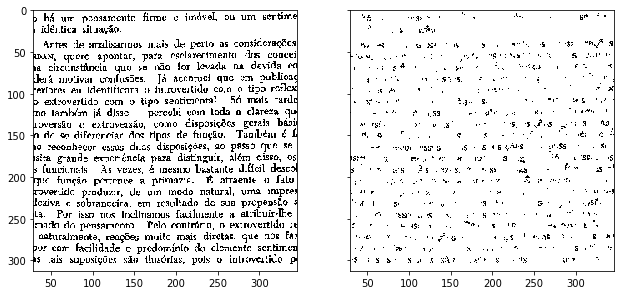

Linha 100 de 313.
Linha 200 de 313.
Linha 300 de 313.


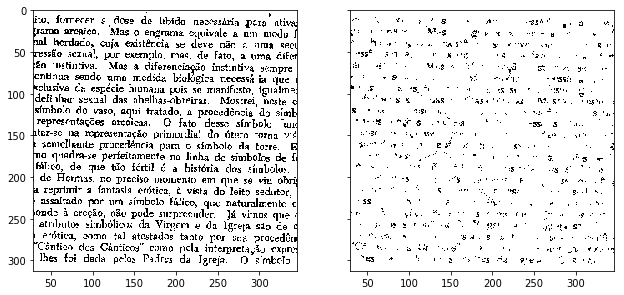

Linha 100 de 313.
Linha 200 de 313.
Linha 300 de 313.


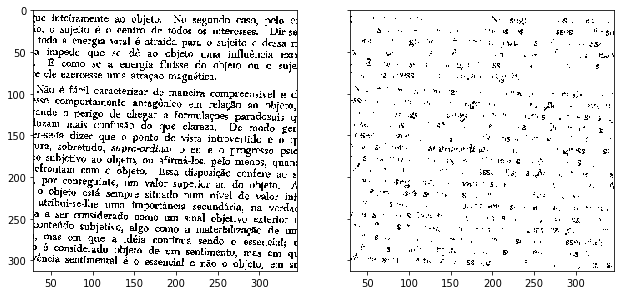

Linha 100 de 313.
Linha 200 de 313.
Linha 300 de 313.


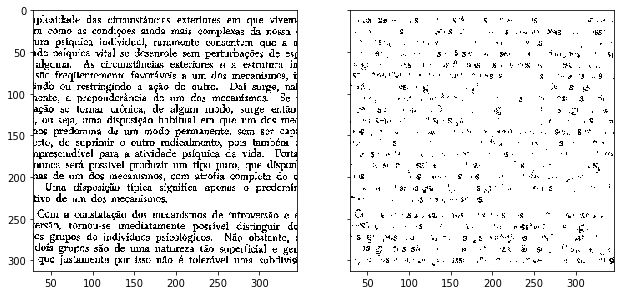

Linha 100 de 313.
Linha 200 de 313.
Linha 300 de 313.


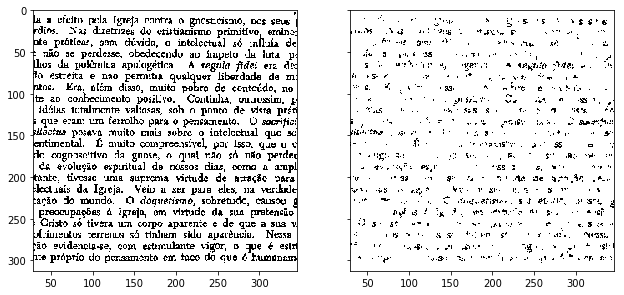

In [29]:
#Aplicação do primeiro W-operador

src_b2=[]
for i in range(len(src_b)):
    src_b2.append(apply_w_operator(src_b[i],w_operator,window,border,default='src'))
    draw_img_pair(src_b[i],src_b2[i])

In [30]:
window2=[rectangular_window(2,1)]
w_operator2=train_w_operator(list(zip(src_b2,dest_b)),window2,border)

Imagem 1 de 5.
Linha 100 de 313.
Linha 200 de 313.
Linha 300 de 313.
Imagem 2 de 5.
Linha 100 de 313.
Linha 200 de 313.
Linha 300 de 313.
Imagem 3 de 5.
Linha 100 de 313.
Linha 200 de 313.
Linha 300 de 313.
Imagem 4 de 5.
Linha 100 de 313.
Linha 200 de 313.
Linha 300 de 313.
Imagem 5 de 5.
Linha 100 de 313.
Linha 200 de 313.
Linha 300 de 313.


Linha 100 de 313.
Linha 200 de 313.
Linha 300 de 313.
Linha 100 de 313.
Linha 200 de 313.
Linha 300 de 313.


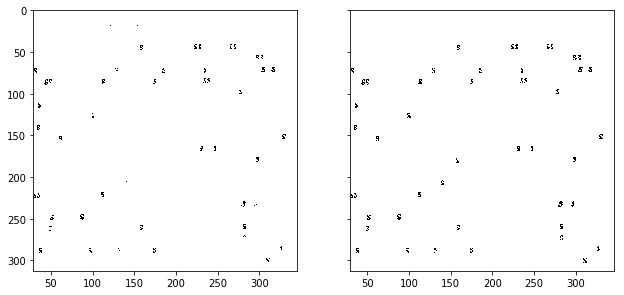

Linha 100 de 313.
Linha 200 de 313.
Linha 300 de 313.
Linha 100 de 313.
Linha 200 de 313.
Linha 300 de 313.


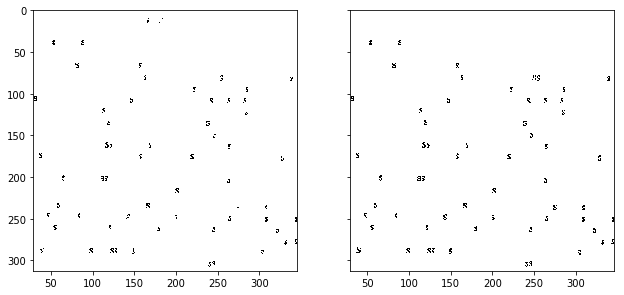

Linha 100 de 313.
Linha 200 de 313.
Linha 300 de 313.
Linha 100 de 313.
Linha 200 de 313.
Linha 300 de 313.


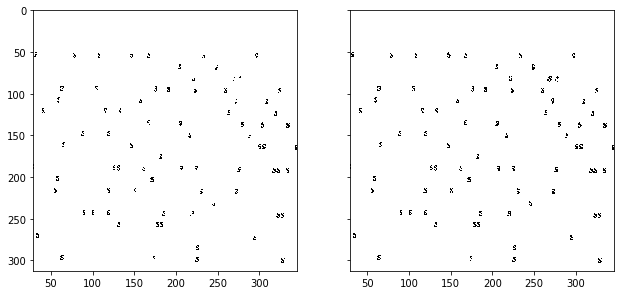

Linha 100 de 313.
Linha 200 de 313.
Linha 300 de 313.
Linha 100 de 313.
Linha 200 de 313.
Linha 300 de 313.


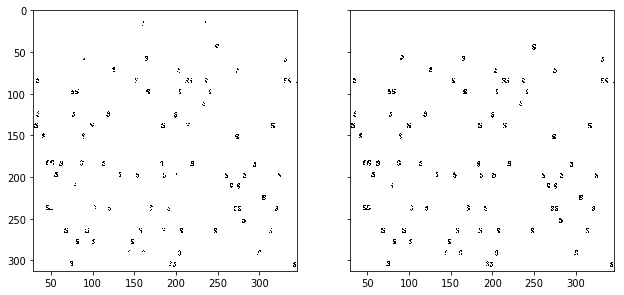

Linha 100 de 313.
Linha 200 de 313.
Linha 300 de 313.
Linha 100 de 313.
Linha 200 de 313.
Linha 300 de 313.


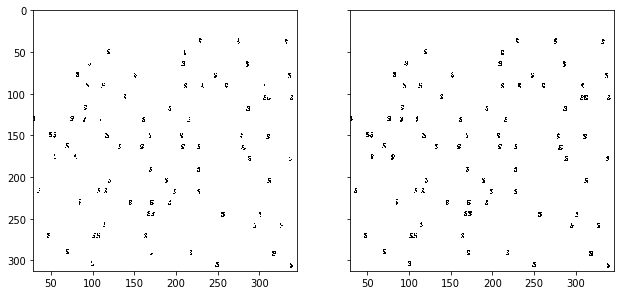

Linha 100 de 313.
Linha 200 de 313.
Linha 300 de 313.
Linha 100 de 313.
Linha 200 de 313.
Linha 300 de 313.


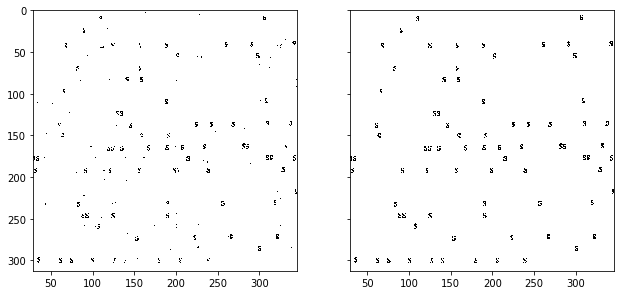

Linha 100 de 313.
Linha 200 de 313.
Linha 300 de 313.
Linha 100 de 313.
Linha 200 de 313.
Linha 300 de 313.


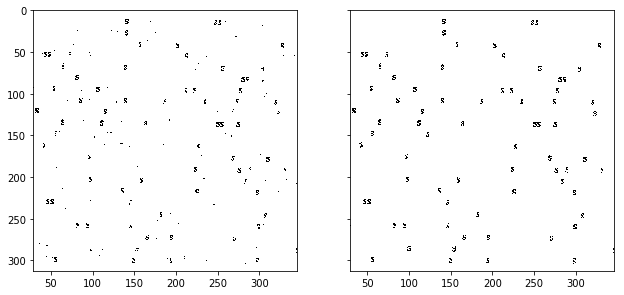

Linha 100 de 313.
Linha 200 de 313.
Linha 300 de 313.
Linha 100 de 313.
Linha 200 de 313.
Linha 300 de 313.


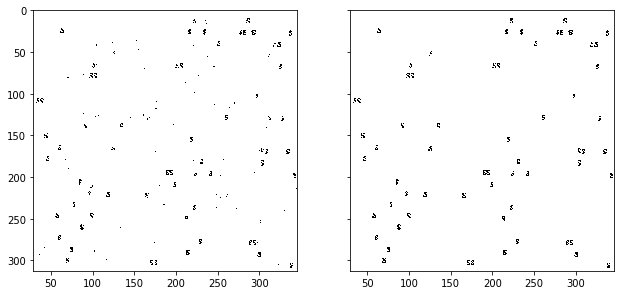

Linha 100 de 313.
Linha 200 de 313.
Linha 300 de 313.
Linha 100 de 313.
Linha 200 de 313.
Linha 300 de 313.


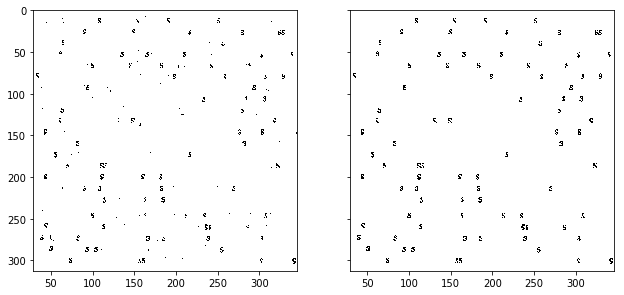

Linha 100 de 313.
Linha 200 de 313.
Linha 300 de 313.
Linha 100 de 313.
Linha 200 de 313.
Linha 300 de 313.


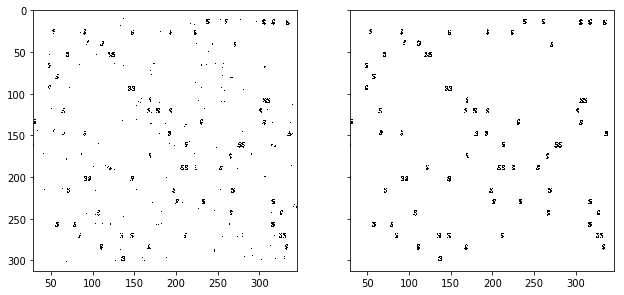

In [31]:
#Aplicação do segundo W-operador
src3=[]
for i in range(len(src)):
    result=apply_w_operator(src[i],w_operator,window,border,default='src')
    result=apply_w_operator(result,w_operator2,window2,border,default=False)
    src3.append(result)
    
    draw_img_pair(result,dest[i])


In [32]:
window3=[rectangular_window(1,1)]
w_operator3=train_w_operator(list(zip(src3,dest)),window3,border)

Imagem 1 de 10.
Linha 100 de 313.
Linha 200 de 313.
Linha 300 de 313.
Imagem 2 de 10.
Linha 100 de 313.
Linha 200 de 313.
Linha 300 de 313.
Imagem 3 de 10.
Linha 100 de 313.
Linha 200 de 313.
Linha 300 de 313.
Imagem 4 de 10.
Linha 100 de 313.
Linha 200 de 313.
Linha 300 de 313.
Imagem 5 de 10.
Linha 100 de 313.
Linha 200 de 313.
Linha 300 de 313.
Imagem 6 de 10.
Linha 100 de 313.
Linha 200 de 313.
Linha 300 de 313.
Imagem 7 de 10.
Linha 100 de 313.
Linha 200 de 313.
Linha 300 de 313.
Imagem 8 de 10.
Linha 100 de 313.
Linha 200 de 313.
Linha 300 de 313.
Imagem 9 de 10.
Linha 100 de 313.
Linha 200 de 313.
Linha 300 de 313.
Imagem 10 de 10.
Linha 100 de 313.
Linha 200 de 313.
Linha 300 de 313.


Imagem 1 de 10.
Linha 100 de 313.
Linha 200 de 313.
Linha 300 de 313.
Linha 100 de 313.
Linha 200 de 313.
Linha 300 de 313.
Linha 100 de 313.
Linha 200 de 313.
Linha 300 de 313.


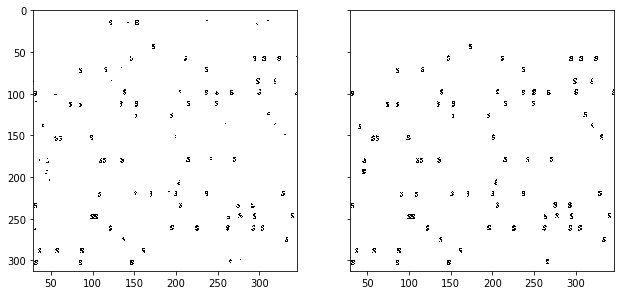

Imagem 2 de 10.
Linha 100 de 313.
Linha 200 de 313.
Linha 300 de 313.
Linha 100 de 313.
Linha 200 de 313.
Linha 300 de 313.
Linha 100 de 313.
Linha 200 de 313.
Linha 300 de 313.


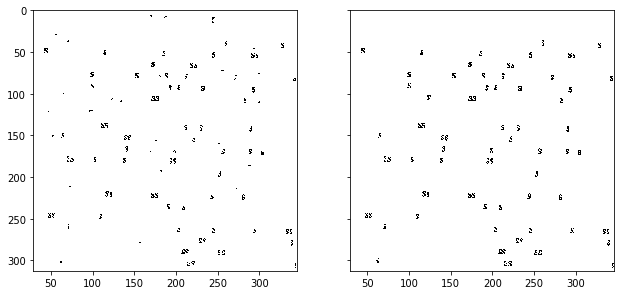

Imagem 3 de 10.
Linha 100 de 313.
Linha 200 de 313.
Linha 300 de 313.
Linha 100 de 313.
Linha 200 de 313.
Linha 300 de 313.
Linha 100 de 313.
Linha 200 de 313.
Linha 300 de 313.


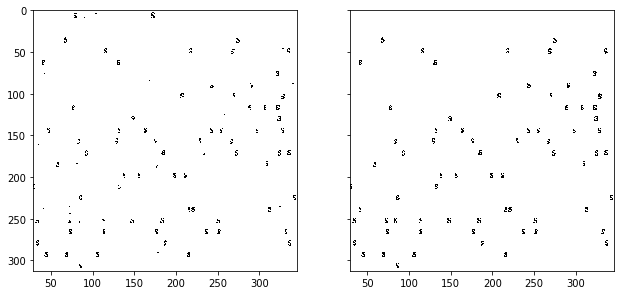

Imagem 4 de 10.
Linha 100 de 313.
Linha 200 de 313.
Linha 300 de 313.
Linha 100 de 313.
Linha 200 de 313.
Linha 300 de 313.
Linha 100 de 313.
Linha 200 de 313.
Linha 300 de 313.


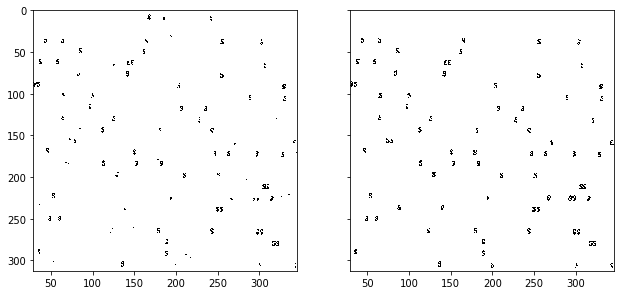

Imagem 5 de 10.
Linha 100 de 313.
Linha 200 de 313.
Linha 300 de 313.
Linha 100 de 313.
Linha 200 de 313.
Linha 300 de 313.
Linha 100 de 313.
Linha 200 de 313.
Linha 300 de 313.


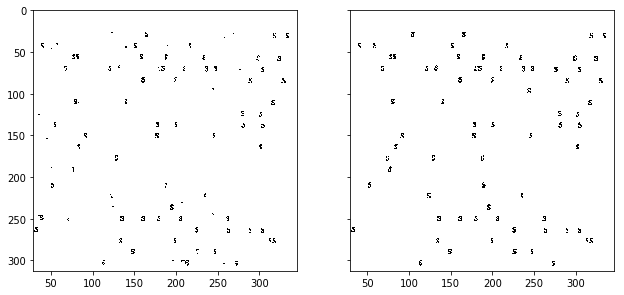

Imagem 6 de 10.
Linha 100 de 313.
Linha 200 de 313.
Linha 300 de 313.
Linha 100 de 313.
Linha 200 de 313.
Linha 300 de 313.
Linha 100 de 313.
Linha 200 de 313.
Linha 300 de 313.


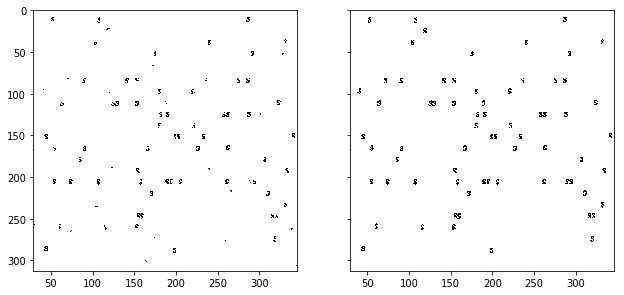

Imagem 7 de 10.
Linha 100 de 313.
Linha 200 de 313.
Linha 300 de 313.
Linha 100 de 313.
Linha 200 de 313.
Linha 300 de 313.
Linha 100 de 313.
Linha 200 de 313.
Linha 300 de 313.


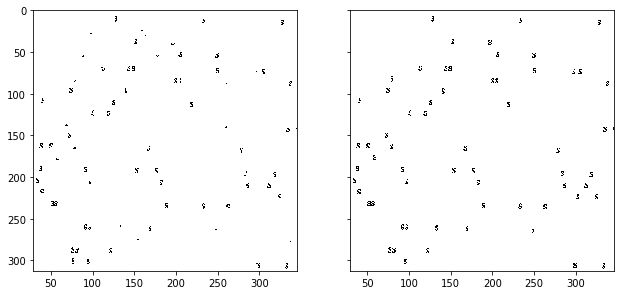

Imagem 8 de 10.
Linha 100 de 313.
Linha 200 de 313.
Linha 300 de 313.
Linha 100 de 313.
Linha 200 de 313.
Linha 300 de 313.
Linha 100 de 313.
Linha 200 de 313.
Linha 300 de 313.


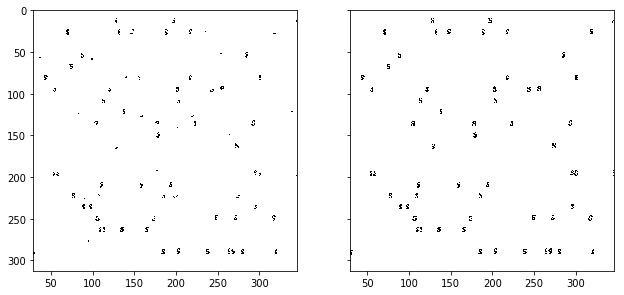

Imagem 9 de 10.
Linha 100 de 313.
Linha 200 de 313.
Linha 300 de 313.
Linha 100 de 313.
Linha 200 de 313.
Linha 300 de 313.
Linha 100 de 313.
Linha 200 de 313.
Linha 300 de 313.


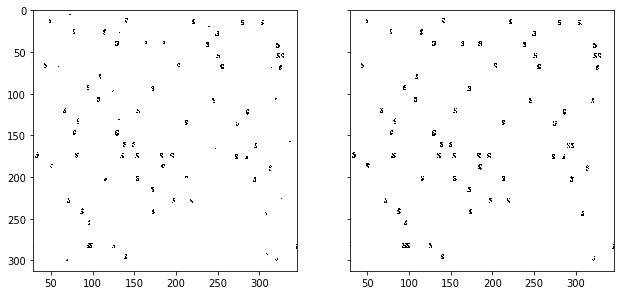

Imagem 10 de 10.
Linha 100 de 313.
Linha 200 de 313.
Linha 300 de 313.
Linha 100 de 313.
Linha 200 de 313.
Linha 300 de 313.
Linha 100 de 313.
Linha 200 de 313.
Linha 300 de 313.


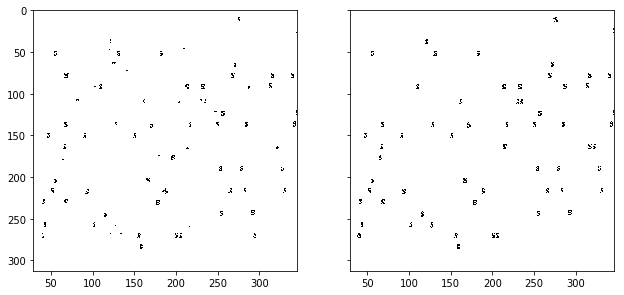

In [33]:
#Aplicação do terceiro e último W-operador
erros=0
test2=[]
test3=[]
test4=[]
for i in range(len(test)):
    print('Imagem '+str(i+1)+' de '+str(len(test))+'.')
    result=apply_w_operator(test[i],w_operator,window,border,default='src')
    test2.append(result)
    result=apply_w_operator(test2[i],w_operator2,window2,border,default=False)
    test3.append(result)
    result=apply_w_operator(test3[i],w_operator3,window3,border,default=True)
    test4.append(result)
    draw_img_pair(test4[i],test_dest[i])
    erros+=(test4[i]!=test_dest[i]).sum()
e_out=erros/(test[0].size*len(test))

In [34]:
e_out

0.0030159744408945685

## Questão 5


Utilizando a técnica de multiresolução, aprenda o operador capaz de remover ruído das imagens da pasta images/q5/. Utilize os pares de imagens (q5_src\*.png, q5_dest.png) para o treinamento e depois teste seu  operador nas imagens q5_test1.png e q5_test2.png.

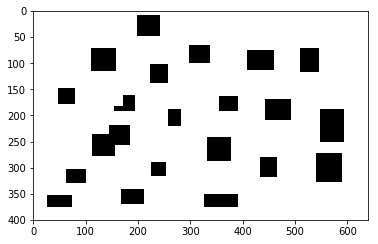

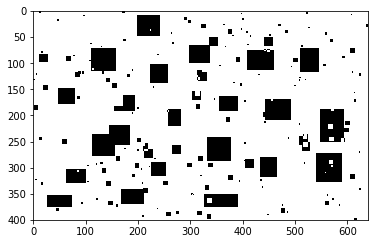

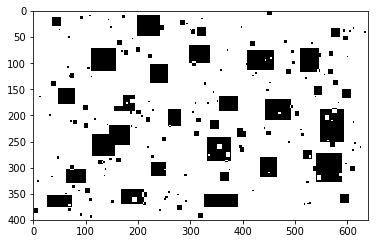

In [35]:
dest5 = read_img("images/q5/q5_dest.png")
src=[]
for i in range(1,10+1):
    globals()['src5_'+str(i)]=read_img("images/q5/q5_src"+str(i)+".png")
    src.append(globals()['src5_'+str(i)])
dest=[dest5]*len(src)
draw_img(dest5)
draw_img(src5_1)
draw_img(src5_2)

In [36]:
multi_window=[]

for i in range(17,-1,-1):
    if i==11 or i==7:
        multi_window.append(cross_point_window(i))
    multi_window.append(cross_window(i))

def border(i,j):
    return False

multi_w_operator=train_w_operator(list(zip(src,dest)),multi_window,border)
threshold=[0]*20
threshold[6]=3000*len(src)
threshold[11]=3000*len(src)


Imagem 1 de 10.
Linha 100 de 400.
Linha 200 de 400.
Linha 300 de 400.
Linha 400 de 400.
Imagem 2 de 10.
Linha 100 de 400.
Linha 200 de 400.
Linha 300 de 400.
Linha 400 de 400.
Imagem 3 de 10.
Linha 100 de 400.
Linha 200 de 400.
Linha 300 de 400.
Linha 400 de 400.
Imagem 4 de 10.
Linha 100 de 400.
Linha 200 de 400.
Linha 300 de 400.
Linha 400 de 400.
Imagem 5 de 10.
Linha 100 de 400.
Linha 200 de 400.
Linha 300 de 400.
Linha 400 de 400.
Imagem 6 de 10.
Linha 100 de 400.
Linha 200 de 400.
Linha 300 de 400.
Linha 400 de 400.
Imagem 7 de 10.
Linha 100 de 400.
Linha 200 de 400.
Linha 300 de 400.
Linha 400 de 400.
Imagem 8 de 10.
Linha 100 de 400.
Linha 200 de 400.
Linha 300 de 400.
Linha 400 de 400.
Imagem 9 de 10.
Linha 100 de 400.
Linha 200 de 400.
Linha 300 de 400.
Linha 400 de 400.
Imagem 10 de 10.
Linha 100 de 400.
Linha 200 de 400.
Linha 300 de 400.
Linha 400 de 400.


Linha 100 de 400.
Linha 200 de 400.
Linha 300 de 400.
Linha 400 de 400.


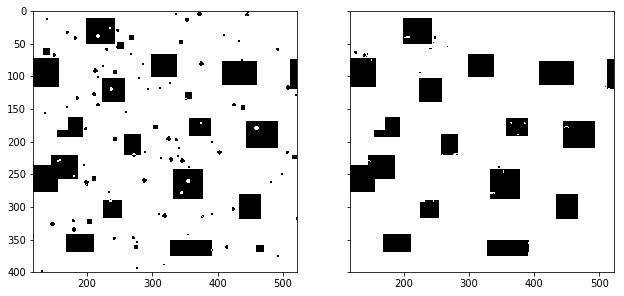

In [37]:
test=read_img('images/q5/q5_test1.png')

test_dest5_1=apply_w_operator(test,multi_w_operator,multi_window,border,default='src',threshold=threshold)
draw_img_pair(test,test_dest5_1)


Linha 100 de 400.
Linha 200 de 400.
Linha 300 de 400.
Linha 400 de 400.


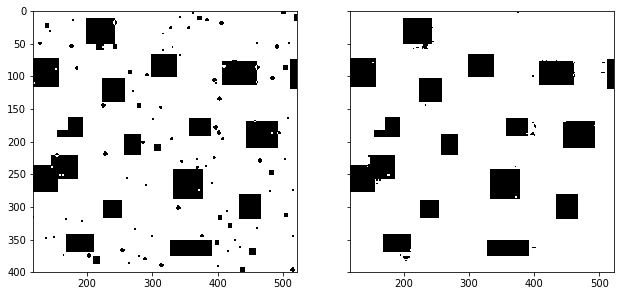

In [38]:
test=read_img('images/q5/q5_test2.png')

test_dest5_2=apply_w_operator(test,multi_w_operator,multi_window,border)
draw_img_pair(test,test_dest5_2)

Linha 100 de 400.
Linha 200 de 400.
Linha 300 de 400.
Linha 400 de 400.


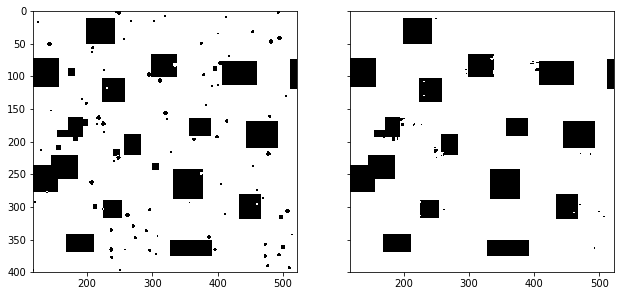

In [39]:
test=read_img('images/q5/q5_test3.png')

test_dest5_3=apply_w_operator(test,multi_w_operator,multi_window,border,default='-src')
draw_img_pair(test,test_dest5_3)

## Questão 6


Utilize a técnica de envelope, como visto em sala, para remover ruído de imagens. Use o mesmo dataset da questão anterior e as funções de morfologia disponíveis em mac0460_5832/utils.py para definir as funções $\alpha$ e $\beta$. Um exemplo de erosão em uma das imagens de treino é mostrado abaixo. Comente sobre a escolha das funções $\alpha$ e $\beta$.

In [40]:
src=[]
for i in range(1,10+1):
    globals()['src6_'+str(i)]=read_img("images/q5/q5_src"+str(i)+".png")
    src.append(globals()['src6_'+str(i)])
#     draw_img(src[i-1])
    
for i in range(1,4):
    globals()['test6_'+str(i)]=read_img("images/q5/q5_test"+str(i)+".png")
    globals()['test_dest6_'+str(i)]=globals()['test_dest5_'+str(i)]

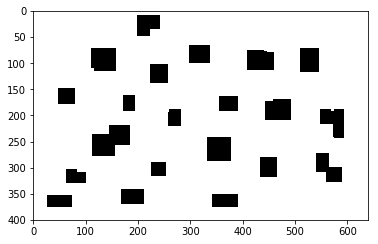

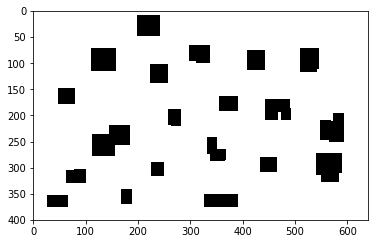

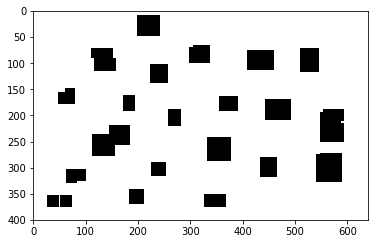

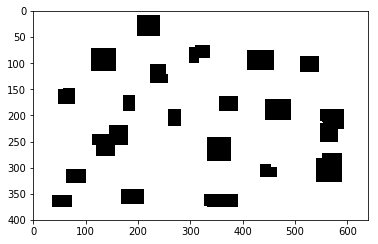

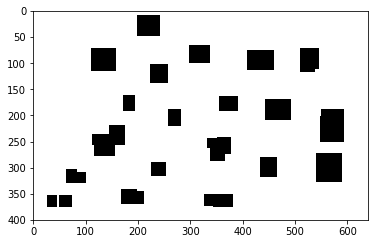

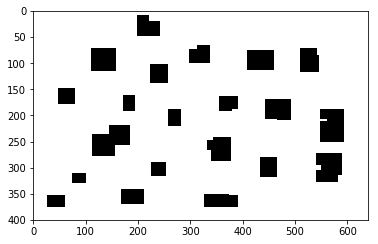

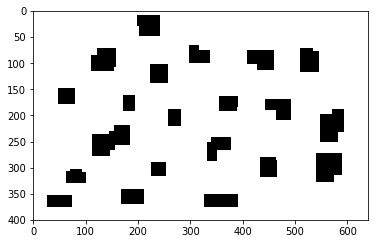

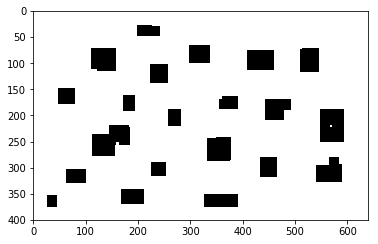

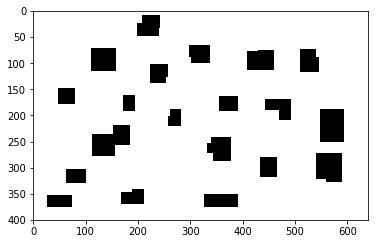

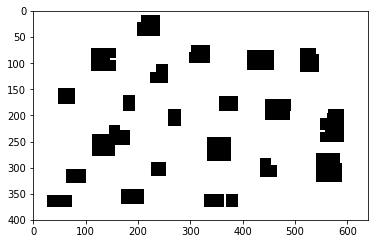

In [41]:
for image in src:
    draw_img(opening(image, se_box(9)))

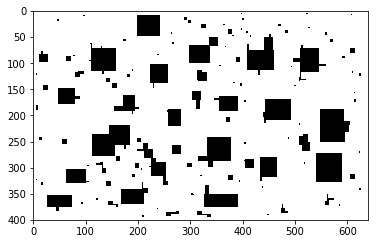

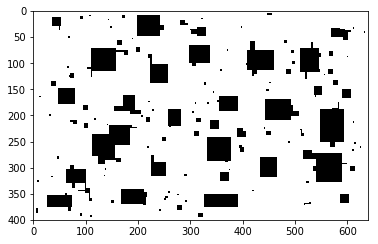

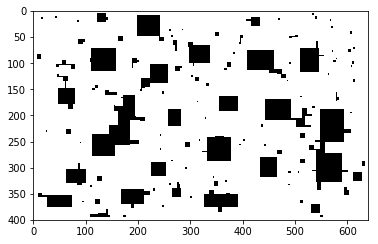

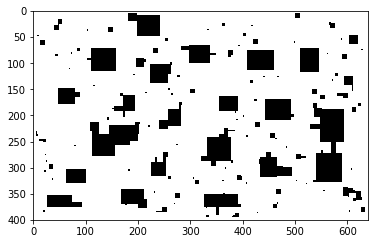

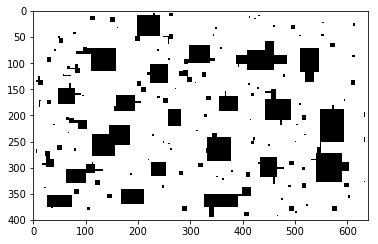

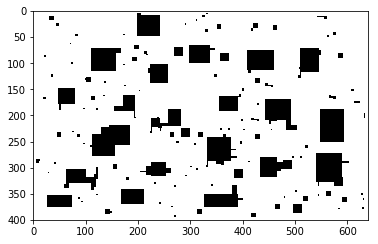

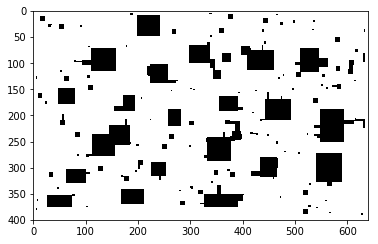

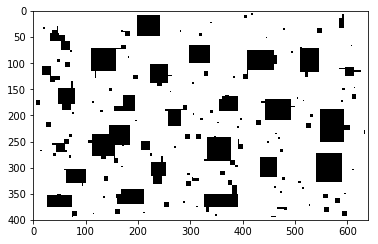

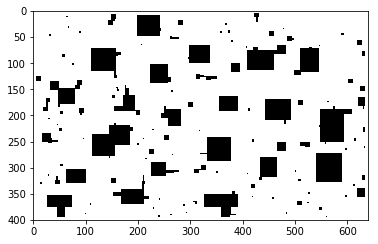

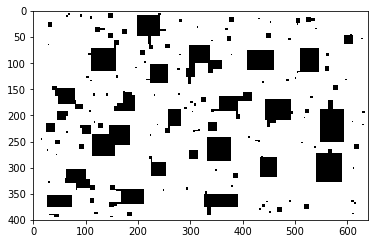

In [42]:
for image in src:
    draw_img(closing(image, se_box(5)))

## Aqui começa a aplicação da técnica do envelope

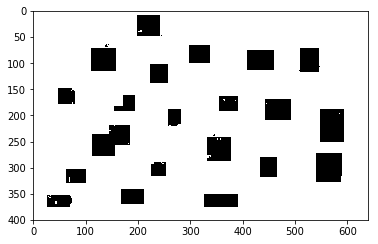

In [43]:
draw_img((opening(test6_1, se_box(9))|test_dest6_1)&closing(test6_1, se_box(5)))

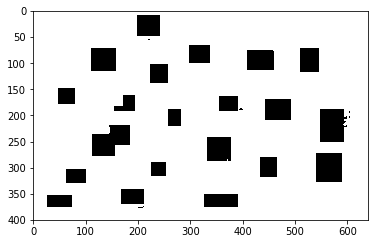

In [44]:
draw_img((opening(test6_2, se_box(9))|test_dest6_2)&closing(test6_2, se_box(5)))

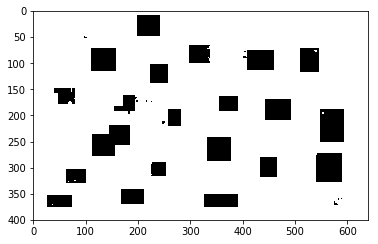

In [45]:
draw_img((opening(test6_3, se_box(9))|test_dest6_3)&closing(test6_3, se_box(5)))

## Questão 7

A função gen_rand_imgs abaixo retorna um par de imagens. A primeira contém alguns pontos gerados aleatoriamente. A segunda é a dilatação da primeira por um elemento estruturante em forma de cruz. Aprenda o operador capaz de realizar essa transformação, gerando os pares de src e dest. Crie os dados de treinamento baseado na equação vista em sala ($m(\epsilon, \delta, H) = \frac{1}{\epsilon}ln\frac{|H|}{\delta}$). Compare o resultado obtido pelo seu classificador (gere mais pares para teste e ter uma estimativa de $E_{out}$) para $\epsilon = [0.2, 0.1]$ e $\delta = [0.3, 0.2]$.

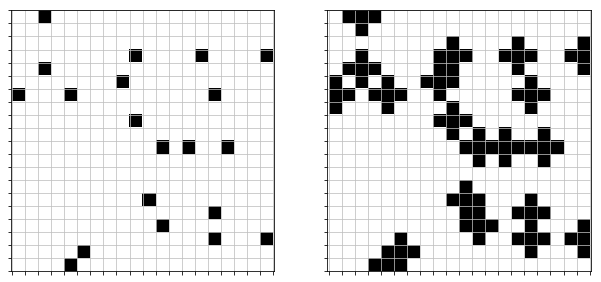

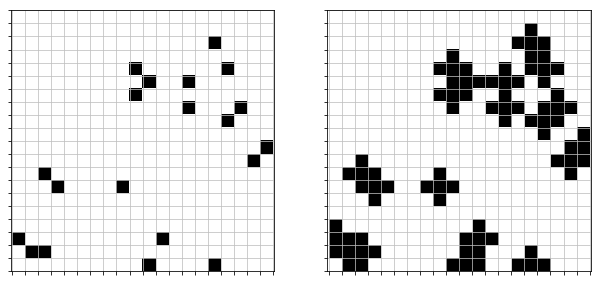

In [178]:
def gen_rand_imgs():
    noise = np.zeros((20, 20)).astype(bool)
    num_pixels = 20
    x = np.random.randint(0, 20, num_pixels)
    y = np.random.randint(0, 20, num_pixels)

    for i in range(num_pixels):
        noise[x[i], y[i]] = 1

    return noise, dilation(noise, se_cross(1))

src7_1, dest7_1 = gen_rand_imgs()
src7_2, dest7_2 = gen_rand_imgs()
draw_img_pair(src7_1, dest7_1)
draw_img_pair(src7_2, dest7_2)

In [179]:
src7_1.size

400

In [180]:
card_H=2**2**5
epsilon=[0.2,0.1]
delta=[0.3,0.2]
m=[None,None]

for i in range(len(m)):
    m[i]=(1/epsilon[i])*np.log((card_H/delta[i]))

In [221]:
imgs=[[],[]]
for i in range(len(m)):
    for j in range(int(np.ceil(m[i]))):
        imgs[i].append(gen_rand_imgs())
        if len(imgs[i])*imgs[i][0][0].size>m[i]:
            break

In [222]:
erro=[0,0]
testes=[]
for j in range(1000):
    testes.append(gen_rand_imgs())

In [223]:
window=[cross_window(1)]
def border(i,j):
    return False

w_operator_0=train_w_operator(imgs[0],window,border,limit=int(np.ceil(m[0])))

Imagem 1 de 1.


In [226]:
erro[0]=0
for j in range(len(testes)):
    erro[0]+=(testes[j][1]!=apply_w_operator(testes[j][0],w_operator_0,window,border=border)).sum()
erro[0]=erro[0]/(testes[0][0].size*len(testes))

In [227]:
window=[cross_window(1)]
def border(i,j):
    return False

w_operator_1=train_w_operator(imgs[1],window,border,limit=int(np.ceil(m[1])))

Imagem 1 de 1.


In [228]:
erro[1]=0
for j in range(len(testes)):
    erro[1]+=(testes[j][1]!=apply_w_operator(testes[j][0],w_operator_1,window,border=border)).sum()
erro[1]=erro[1]/(testes[0][0].size*len(testes))

In [229]:
m

[116.92341291122092, 237.90147690352347]

In [230]:
#erro[0] é o erro para o operador treinado com m[0] imagens
#erro[1] é o erro para o operador treinado com m[1] imagens
erro

[0.0187175, 0.015125]

In [231]:
len(w_operator_0[0])

6

In [233]:
len(w_operator_1[0])

8

In [106]:
print(datetime.datetime.now().strftime('%d/%m/%Y %H:%M:%S'))

05/10/2018 17:08:45
